#AIRBNB CLASSIFIER

# Introduction

Airbnb is an online marketplace that lets property owners rent out their spaces to travelers looking for a place to stay. Every day, Hosts offer unique stays and one-of-a-kind activities that make it possible for guests to experience the world in a more authentic, connected way.

Since its establishment in 2008, Airbnb has developed rapidly. Undoubtedly, its development has brought a great impact on the traditional hotel industry. However, as more competitive enterprises enter this industry, Airbnb must meet more challenges and the loss of market share. In addition, with the advent of the epidemic, Airbnb's global short rent business has been greatly impacted. According to data, the pandemic directly led to a huge loss for Airbnb. How will Airbnb develop in the future? To retain the highest market share, we propose that Airbnb should concentrate on building more user-friendly applications.

# Overall Data

Our dataset is directly pulled from the Airbnb website. We have two datasets that we are using, “listings.csv” and “review.csv”. The dataset ‘listings’ contains 6,529 samples and ‘reviews’ contain 302,750 samples. There are 36 features that we are using from both datasets. The ‘listings.csv’ dataset contains information about the host accommodations (such as neighborhood, room type, number of bathrooms, etc.) and the ‘review.csv’ contains customer review information. Our classification variable is “Price” which we have divided based on the price point of 126 (which is the average value when outliers removed). Values above 126 we have labeled luxury, and values below 126 we have labeled Economy. We will look at the distribution of the classification variable later in the report. 

**dataset link**

http://insideairbnb.com/get-the-data.html

Import statements:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import imblearn
#graphviz
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols
from sklearn.tree import export_graphviz
from IPython.display import Image 
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from pprint import pprint 
import sys
import pydotplus
import geopy
import numpy as np
import warnings                                               
warnings.filterwarnings("ignore")
import seaborn as sns

import json
from google.colab import files
import random
import nltk
# downlaod some resouces
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# load the sentiment function
sia = SentimentIntensityAnalyzer()
# load the stemmer function 
porter = nltk.PorterStemmer()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Descriptive Analytics:

In [ ]:
#load in airbnb dataset

df = pd.read_csv('listings.csv') 
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20211018161857,2021-10-19,Hyde Park - Walk to University of Chicago,"If you are fully vaccinated, and able to climb...",The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,83%,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, Illinois, United States",Hyde Park,NaN,41.78790,-87.58780,Private room in condominium (condo),Private room,1,NaN,1 shared bath,1.0,1.0,"[""Hot water"", ""Gas stove"", ""Essentials"", ""Room...",$81.00,3,30,3,3,1125,1125,3.0,1125.0,NaN,t,19,40,55,329,2021-10-19,190,10,2,2015-04-30,2021-09-24,4.99,4.98,4.99,4.98,4.98,4.95,4.94,R17000015609,f,1,0,1,0,2.41
1,7126,https://www.airbnb.com/rooms/7126,20211018161857,2021-10-18,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",https://a0.muscache.com/pictures/51073/16c81c7...,17928,https://www.airbnb.com/users/show/17928,Sarah,2009-05-19,"Chicago, Illinois, United States",We live in Chicago. We love to travel and see ...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/17928/profile...,https://a0.muscache.com/im/users/17928/profile...,Ukrainian Village,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Chicago, Illinois, United States",West Town,NaN,41.90166,-87.68021,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Hot water"", ""Stove"", ""Essentials"", ""Room-dar...",$65.00,2,60,2,2,1125,1125,2.0,1125.0,NaN,t,5,22,48,230,2021-10-18,414,29,6,2011-08-10,2021-10-06,4.66,4.83,4.53,4.89,4.86,4.87,4.72,R18000034991,f,1,1,0,0,3.34
2,10945,https://www.airbnb.com/rooms/10945,20211018161857,2021-10-18,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,https://a0.muscache.com/pictures/58d1a420-a24b...,33004,https://www.airbnb.com/users/show/33004,At Home Inn,2009-08-21,"Chicago, Illinois, United States","Hi, we're Bob and Liz Biddle, long time Chicag...",within an hour,94%,92%,t,https://a0.muscache.com/im/pictures/user/e23d4...,https://a0.muscache.com/im/pictures/user/e23d4...,Old Town,7.0,7.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Lincoln Park,NaN,41.91196,-87.63981,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Hot water"", ""Stove"", ""Essentials"", ""Kitchen""...",$125.00,4,180,4,4,180,180,4.0,180.0,NaN,t,12,33,54,144,2021-

In [ ]:
#see the distribution of our data
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,6.528000e+03,6.528000e+03,6.528000e+03,6525.000000,6525.000000,0.0,6528.000000,6528.000000,6528.000000,0.0,5953.000000,6469.000000,6528.000000,6528.000000,6528.000000,6528.000000,6.528000e+03,6.528000e+03,6528.000000,6.528000e+03,0.0,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,5510.000000,5478.000000,5478.000000,5477.000000,5476.000000,5477.000000,5477.000000,6528.000000,6528.000000,6528.000000,6528.000000,5510.000000
mean,3.305271e+07,2.021102e+13,1.217399e+08,109.245977,109.245977,NaN,41.898251,-87.663115,4.092371,NaN,1.768016,2.115010,9.211397,694.827512,10.242647,44.216452,5.593242e+06,7.567086e+06,42.599081,7.562612e+06,NaN,12.023591,28.333333,46.912990,178.385110,46.377145,11.925858,1.491881,4.705561,4.795285,4.727786,4.852027,4.848402,4.785941,4.694691,22.345895,20.532016,1.533241,0.151654,3.521632
std,1.494224e+07,9.297587e-01,1.200565e+08,446.715318,446.715318,NaN,0.058499,0.042220,2.851444,NaN,1.078304,1.722313,22.728897,504.515065,33.852630,156.131612,1.094539e+08,1.272537e+08,151.275062,1.271786e+08,NaN,11.293922,22.799640,33.850881,137.490354,75.133071,22.877154,2.437626,0.533349,0.365877,0.399645,0.319597,0.349536,0.342330,0.397080,66.699864,67.029716,3.737208,1.413448,7.855918
min,2.384000e+03,2.021102e+13,2.153000e+03,0.000000,0.000000,NaN,41.650640,-87.864150,0.000000,NaN,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.140874e+07,2.021102e+13,2.191582e+07,1.000000,1.000000,NaN,41.872585,-87.686815,2.000000,NaN,1.000000,1.000000,1.000000,60.000000,2.000000,2.000000,3.650000e+02,1.124000e+03,2.000000,9.736000e+02,NaN,0.000000,0.000000,7.000000,44.000000,2.000000,0.000000,0.000000,4.660000,4.750000,4.640000,4.840000,4.840000,4.730000,4.620000,1.000000,1.000000,0.000000,0.000000,0.530000
50%,3.652392e+07,2.021102e+13,8.490272e+07,2.000000,2.000000,NaN,41.899715,-87.659450,4.000000,NaN,1.000000,2.000000,2.000000,1125.000000,2.000000,3.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,NaN,11.000000,31.000000,54.000000,166.000000,16.000000,4.000000,0.000000,4.840000,4.900000,4.850000,4.940000,4.960000,4.890000,4.790000,2.000000,1.000000,0.000000,0.000000,1.720000
75%,4.641521e+07,2.021102e+13,1.915230e+08,10.000000,10.000000,NaN,41.938783,-87.632417,5.000000,NaN,2.000000,3.000000,4.000000,1125.000000,4.000000,6.000000,1.125000e+03,1.125000e+03,5.000000,1.125000e+03,NaN,22.250000,49.000000,78.000000,327.000000,57.000000,18.000000,3.000000,4.960000,5.000000,4.980000,5.000000,5.000000,5.000000,4.910000,9.000000,5.000000,1.000000,0.000000,3.760000
max,5.282783e+07,2.021102e+13,4.273566e+08,5897.000000,5897.000000,NaN,42.022200,-87.535880,16.000000,NaN,12.000000,25.000000,500.000000,1125.000000,730.000000,730.000000,2.147484e+09,2.147484e+09,730.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,1390.000000,982.000000,65.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,313.000000,313.000000,26.000000,17.000000,2

Lets create our classification variable. We will be using price as our classification variable. The average value is 126 (after removing outliers) so we will create two classifcation variables using price Economy (price below 126) and Luxury (price above 126):

In [ ]:
#Since price does not have any null values we can immediately create our classification variable:
df['PriceClass'] = 'na'

df.price= df['price'].str.replace("$", '')
df.price= df['price'].str.replace(",", '')
df.price = df['price'].astype(float)

for index, value in enumerate(df.price): 
  if value <= 126 :
    df['PriceClass'][index] = 'Economy'
  else:
    df['PriceClass'][index] = 'Luxury'

y = df.loc[:,['price', 'PriceClass']].values
print(y)

[[81.0 'Economy']
 [65.0 'Economy']
 [125.0 'Economy']
 ...
 [105.0 'Economy']
 [229.0 'Luxury']
 [175.0 'Luxury']]


In [ ]:
print(df.groupby('neighbourhood_cleansed').count().reset_index()['neighbourhood_cleansed'])

0        Albany Park
1     Archer Heights
2      Armour Square
3            Ashburn
4     Auburn Gresham
           ...      
71         West Lawn
72      West Pullman
73        West Ridge
74         West Town
75          Woodlawn
Name: neighbourhood_cleansed, Length: 76, dtype: object


As our task is predicting the price class, it’s necessary to visualize the distribution of each class. Below is a bar chart showing the distribution of each class: 

(Text(0.5, 0, 'Class'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of Each Class'))

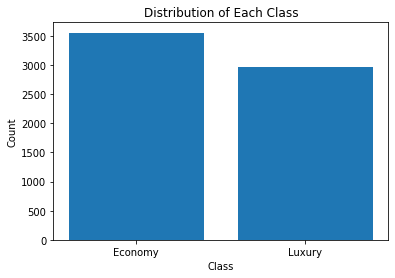

In [ ]:
temp = pd.DataFrame(df.groupby('PriceClass').host_id.count()).reset_index().rename(columns={"host_id":"number_of_host"})
temp
plt.bar(temp['PriceClass'], temp['number_of_host'])
plt.xlabel('Class'),plt.ylabel('Count'),plt.title('Distribution of Each Class')

From the above graph we can learn that the proportion of these two classes is close to 1: 1. Therefore, it’s not necessary to use machine learning tools like SMOTE to balance the data. 

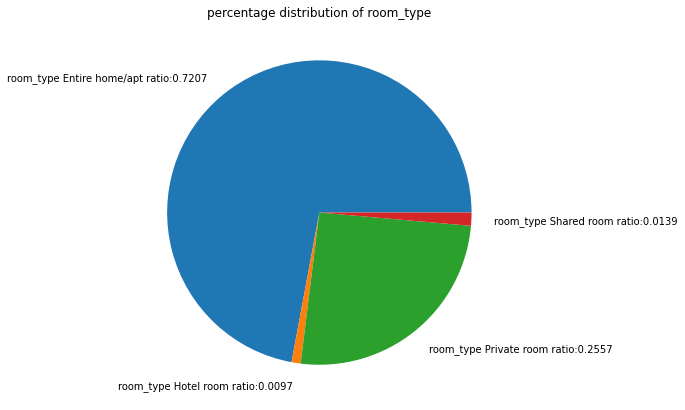

In [ ]:
# Let's take a look at percentage distribution of room_type
visulization = df.copy()
temp = visulization.groupby('room_type').count().reset_index()
plt.figure(figsize=(7,7))
length = len(visulization.room_type)
temp['ratio'] = temp['host_id']/length
ratio_each_type = temp[['room_type','ratio']]
names = []
for index,value in enumerate(ratio_each_type['room_type']):
  value = 'room_type '  + str(value) + ' ratio:'+ str(round(ratio_each_type['ratio'][index],4))
  names.append(value)
plt.pie(ratio_each_type['ratio'],labels=names,labeldistance=1.15)
plt.title('percentage distribution of room_type')
plt.show()

In our data, we converted a few features from categorical variables into dummy variables. Below is an example of a categorical variable, room_type, which we split into dummy variables that our model could process:

We also wanted to take a look at how price is distributed in each class, to make sure that the range of each of the classes is not too different. Below is a frequency distribution of price with the dotted line representing the divide between economy and luxury:

(0.0, 2000.0)

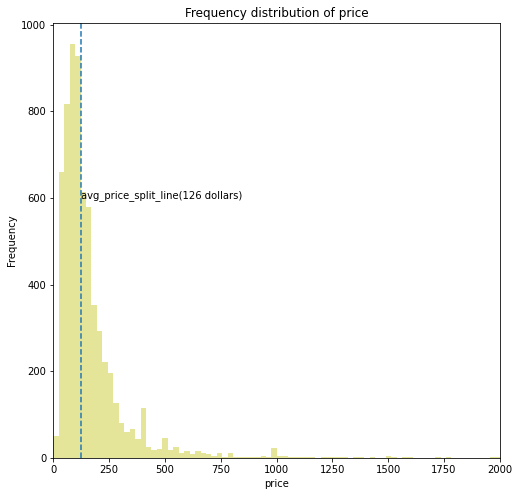

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,8))
# Plot the histogram thanks to the distplot function
sns.distplot( a=df["price"], hist=True, kde=False, rug=False ,bins=2000,color="y")
plt.ylabel('Frequency'),plt.title('Frequency distribution of price')
plt.axvline(126,linestyle='--'),
plt.text(126,600,'avg_price_split_line(126 dollars)')
plt.xlim(0,2000)

We can conclude that the majority of price in Economy is close to 100 while most of the price in Luxury is between 126 and 250 dollars.

#Benchmarking (without Preprocessing): 

Although this initial benchmarking is for our accuracy scores before pre-processing, we still needed to do some pre-processing in order for data to be accepted in the various different models. This mainly consisted of replacing null values (which we replaced with the column averages in this benchmark) and creating dummy variables for categorical variables. An example of this is the feature ‘bathrooms_text’. For this feature we first had to separate the numeric value from the text, fill any null values with the averages of the numeric values, and then convert the text (which were categorical data) into dummy variables. 
To keep the integrity of our benchmark we tried to do as little pre-processing as possible in this stage to see the efficiency and accuracy of our models (this means that some of the features in the initial benchmarking stage were not used as they would have required extensive pre-processing to be included in the model). The following segment of the report will go over a brief explanation of the model and our initial benchmark without preprocessing.


For our intial benchmarking, we are replacing na values with average (instead of removing the rows because if we remove rows there is huge information loss) and we are convertinig categorical variables into dummy variables. 

In [ ]:
df1 = df.copy()
#df1.dropna(inplace = True)
#df1.info()
#print(y)
#print(df.head())

#feature pre-processing
columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'PriceClass']
features = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'latitude', ' longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

#replace t and f with 1 and 0 
df1.replace(to_replace={'host_is_superhost' : {'t': 1, 'f' : 0}, 'host_has_profile_pic' : {'t' : 1, 'f' : 0},'host_identity_verified' : {'t' : 1, 'f' : 0}, 'PriceClass':{'Economy': 0, 'Luxury': 1} }, inplace = True)


#host response rate: na 1466
df1.host_response_rate= df1['host_response_rate'].str.replace("%", '')
df1.host_response_rate = df1['host_response_rate'].astype(float)
df1['host_response_rate'].fillna(df1.host_response_rate.mean(), inplace = True)


#host_acceptance_rate: na 1300
df1.host_acceptance_rate= df1['host_acceptance_rate'].str.replace("%", '')
df1.host_acceptance_rate = df1['host_acceptance_rate'].astype(float)
df1['host_acceptance_rate'].fillna(df1.host_acceptance_rate.mean(), inplace = True)
df1.host_acceptance_rate.isna().sum()
#print(df.host_acceptance_rate.isna().sum())

#host_is_superhost: na 3 (checked url and they were all superhost)
df1['host_is_superhost'].fillna(1, inplace = True)
#df1.host_is_superhost.isna().sum()

#host_has_profile_pic: na 3 (checked url and they all had profile)
df1['host_has_profile_pic'].fillna(1, inplace = True)
#df1.host_has_profile_pic.isna().sum()

# host_identity_verified: na 3 (checked url and they all were verified)
df1['host_identity_verified'].fillna(1, inplace = True)
#df1.host_identity_verified.isna().sum()

#latitude: na 0
#df1.latitude.isna().sum()

#longitude: na 0
#df1.longitude.isna().sum()

#room_type: na 0 (we need to use dummy variables to represent this in our data)
#df1.room_type.isna().sum()
room_type = pd.get_dummies(df1['room_type'],drop_first=True)
#print(room_type)

#accommodates: na 0 
#df1.accommodates.isna().sum()

#bathrooms_text (we need to divide this into number of bath and type of bath)
split = df1['bathrooms_text'].str.split(' ').str[0]
for j, i in enumerate(split): 
  if not str(i).isnumeric() and '.' not in str(i):
    if pd.isnull(i):
      split[j] = 1
    else:
      split[j] = 0.5
df1['num_bathrooms'] = split
split = df1['bathrooms_text'].str.split(' ').str[1]
for j,i in enumerate(split):
  if not (i == 'shared' or i == 'private'):
    split[j] = 'bath'
df1['bathrooms_type'] = split
bathrooms_type = pd.get_dummies(df1['bathrooms_type'],drop_first=True)

#bedrooms: na 575
df1['bedrooms'].fillna(df1.bedrooms.mean(), inplace = True)
#df1.bedrooms.isna().sum()

#beds: na 59
df1.beds.fillna(df1.beds.mean(), inplace = True)
#df.beds.isna().sum()

#minimum_nights: na 0
#print(df.minimum_nights.isna().sum())

#maximum_nights: na 0 
#print(df.maximum_nights.isna().sum())

#number_of_reviews: na 
#print(df.number_of_reviews.isna().sum())

#review_scores_rating: na 1050
df1.review_scores_rating.fillna(df1.review_scores_rating.mean(), inplace = True)
#print(df.review_scores_rating.isna().sum())

#review_scores_accuracy: na 1050
df1.review_scores_accuracy.fillna(df1.review_scores_accuracy.mean(), inplace = True)
#print(df.review_scores_accuracy.isna().sum())

#review_scores_cleanliness: na 1050
df1.review_scores_cleanliness.fillna(df1.review_scores_cleanliness.mean(), inplace = True)
#print(df.review_scores_accuracy.isna().sum())

#review_scores_checkin: na 1051
df1.review_scores_checkin.fillna(df1.review_scores_checkin.mean(), inplace = True)
#print(df.review_scores_checkin.isna().sum())

#review_scores_communication: na 1052
df1.review_scores_communication.fillna(df1.review_scores_communication.mean(), inplace = True)
#print(df.review_scores_communication.isna().sum())

#review_scores_location: na 1051
df1.review_scores_location.fillna(df1.review_scores_location.mean(), inplace = True)
#print(df.review_scores_location.isna().sum())

#review_scores_value: na 1051
df1.review_scores_value.fillna(df1.review_scores_value.mean(), inplace = True)
#print(df1.review_scores_value.isna().sum())

#reviews_per_month: na 1018
df1.reviews_per_month.fillna(df1.reviews_per_month.mean(), inplace = True)
#print(df.reviews_per_month.isna().sum())


#reminder concat room_type and drop room_type col, bathrooms_text
df1.drop(['room_type', 'bathrooms_text'],axis=1,inplace=True)
df1 = pd.concat([df1,room_type, bathrooms_type],axis=1)

df1.rename(columns = {"Hotel room":"Hotel_room", "Private room": "Private_room", "Shared room": "Shared_room"}, inplace = True)

new_features = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'latitude', 'longitude', 'Hotel_room', 'Private_room', 'Shared_room', 'private', 'shared', 'num_bathrooms', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
classification = ['PriceClass']

df1.num_bathrooms = df1['num_bathrooms'].astype(float)
df1.info()
print(df1['PriceClass'].value_counts)
print(df.PriceClass.value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 80 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6528 non-null   int64  
 1   listing_url                                   6528 non-null   object 
 2   scrape_id                                     6528 non-null   int64  
 3   last_scraped                                  6528 non-null   object 
 4   name                                          6528 non-null   object 
 5   description                                   6512 non-null   object 
 6   neighborhood_overview                         4755 non-null   object 
 7   picture_url                                   6528 non-null   object 
 8   host_id                                       6528 non-null   int64  
 9   host_url                                      6528 non-null   o

In [ ]:
logit_model = logit('PriceClass ~ host_response_rate + host_acceptance_rate + host_is_superhost + host_has_profile_pic + host_identity_verified + latitude + longitude + Hotel_room + Private_room + Shared_room + private + shared + num_bathrooms + accommodates + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + reviews_per_month', df1).fit()
print(logit_model.summary())



Optimization terminated successfully.
         Current function value: 0.460999
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             PriceClass   No. Observations:                 6528
Model:                          Logit   Df Residuals:                     6500
Method:                           MLE   Df Model:                           27
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.3310
Time:                        08:10:44   Log-Likelihood:                -3009.4
converged:                       True   LL-Null:                       -4498.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1170.1033     79.902     14.644      0.000   

From the results, we can see that we have several strong predictors: 

•	host_response_rate

•	host_identity_verified

•	latitude/longitude

•	Hotel_room/Private_room/Shared_room

•	num_bathrooms

•	accommodates

•	bedrooms/beds

•	number_of_reviews

•	review_scores_cleanliness

•	review_scores_location

•	review_scores_value

One thing to be wary of is our R-squared value (0.33) which is relatively low. Although this is not necessarily an indicator of a strong or poor model, it is important to keep in mind when assessing the strength of it. When we remove the insignificant values, our R-squared drops (as there is information loss) but not significantly indicating that the predictors listed above are our strongest. We are not looking at any accuracy score’s with this model as we want to use the same package when comparing accuracy. We will take a look at the accuracy in the following model. 


In [ ]:
X = df1[new_features]
y = df1[classification]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,Hotel_room,Private_room,Shared_room,private_baths,shared_baths,num_bathrooms,accommodates,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_response_time1,host_response_time2,host_response_time3,host_listings_count,pos,neg,compound,neu,PriceClass
0,1.000000,0.830000,1.0,1.0,1.0,41.787900,-87.587800,0,1,0,0,1,1.0,1,1.0,1.0,3,30,190,4.99,4.98,4.99,4.98,4.98,4.95,4.94,2.41,0,0,1,1.0,0.410258,0.014074,0.912579,0.575663,0
1,0.973658,0.881706,1.0,1.0,1.0,41.901660,-87.680210,0,0,0,0,0,1.0,2,1.0,1.0,2,60,414,4.66,4.83,4.53,4.89,4.86,4.87,4.72,3.34,0,0,0,2.0,0.403053,0.018220,0.836953,0.576304,0
2,0.940000,0.920000,1.0,1.0,1.0,41.911960,-87.639810,0,0,0,0,0,1.0,4,2.0,2.0,4,180,36,4.58,4.67,4.72,4.75,4.72,4.97,4.56,0.40,0,0,1,7.0,0.430639,0.022083,0.818631,0.547333,0
3,1.000000,0.930000,0.0,1.0,1.0,41.904910,-87.632130,0,0,0,0,0,1.0,2,1.0,1.0,7,180,13,4.75,4.75,4.75,4.67,4.75,4.75,4.75,0.16,0,0,1,3.0,0.350692,0.027077,0.935954,0.622308,0
4,1.000000,1.000000,0.0,1.0,1.0,41.923570,-87.649470,0,1,0,1,0,1.0,2,1.0,2.0,2,7,7,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.09,0,0,1,1.0,0.434714,0.000000,0.869414,0.565286,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6477,1.000000,1.000000,0.0,1.0,1.0,41.915676,-87.635582,0,0,0,0,0,1.0,4,1.0,1.0,3,365,2,5.00,5.00,5.00,4.50,5.00,5.00,4.50,2.00,0,0,1,0.0,0.557500,0.000000,0.955200,0.442500,0
6478,1.000000,1.000000,1.0,1.0,1.0,41.886090,-87.615630,0,0,0,0,0,1.0,2,1.0,1.0,1,365,2,5.00,5.00,4.50,5.00,5.00,5.00,4.50,2.00,0,0,1,4.0,0.390000,0.000000,0.935550,0.610000,1
6488,1.000000,0.900000,0.0,1.0,1.0,41.859630,-87.660060,0,1,0,0,1,1.0,2,1.0,1.0,1,365,1,5.00,5.00,4.00,5.00,5.00,5.00,4.00,1.00,0,0,1,2.0,0.458000,0.086000,0.926500,0.456000,0
6490,1.000000,0.990000,1.0,1.0,1.0,41.969760,-87.673120,0,0,0,0,0,1.5,4,1.0,2.0,1,1125,2,5.00,4.50,4.50,5.00,5.00,5.00,5.00,2.00,0,0,1,7.0,0.589500,0.000000,0.869800,0.410500,0


In [ ]:
#logistic regression
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[903 203]
 [273 580]]
Accuracy: 0.7570188871873405
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1106
           1       0.74      0.68      0.71       853

    accuracy                           0.76      1959
   macro avg       0.75      0.75      0.75      1959
weighted avg       0.76      0.76      0.76      1959



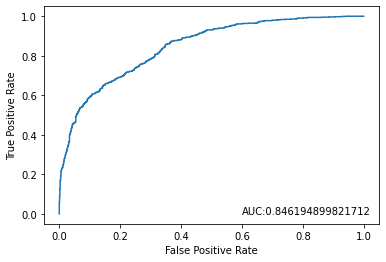

In [ ]:
#create ROC curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.6,0,'AUC:'+str(metrics.auc(fpr, tpr)))
plt.show()

Text(0.5, 257.44, 'Predicted label')

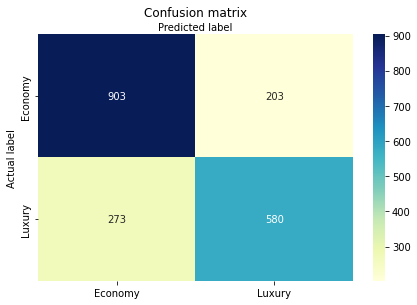

In [ ]:
class_names = ['Economy','Luxury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)).rename(columns={0:'Economy',1:'Luxury'},index={0:'Economy',1:'Luxury'})
, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

We can see from the results that when no preprocessing is done (or very minimal pre-processing), that the accuracy is approximately 0.76. Our classifier correctly identified 903 elements as Economy out of 1106 possible elements (203 incorrectly classified) and classified 580 elements Luxury out of 853 possible elements (273 incorrectly classified). The AUC is also 0.84, which is in between 0.5 and 1, and indicates that our model can distinguish the two class models pretty well. We can also see that our precision for both 0 and 1 is above .7 and likewise with our f1-score. So without pre-processing our model is already looking pretty good. In our “with pre-processing” section we will try to see if we can improve this accuracy. 

In [ ]:
#decision trees
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[733 373]
 [170 683]]
Accuracy: 0.7228177641653905
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1106
           1       0.65      0.80      0.72       853

    accuracy                           0.72      1959
   macro avg       0.73      0.73      0.72      1959
weighted avg       0.74      0.72      0.72      1959



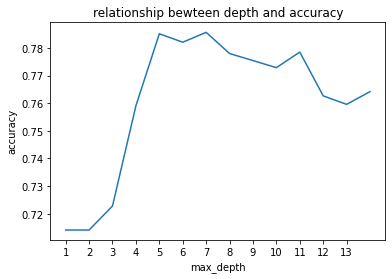

In [ ]:
x = []
y = []
for n in range(1,15):

  clf = DecisionTreeClassifier(criterion="entropy", max_depth=n)
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  y.append(metrics.accuracy_score(y_test, y_pred))
  x.append(n)
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
plt.plot(x,y)
xticks = np.arange(x[0],x[-1],1)
plt.xticks(xticks)
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.title('relationship bewteen depth and accuracy')
plt.show()

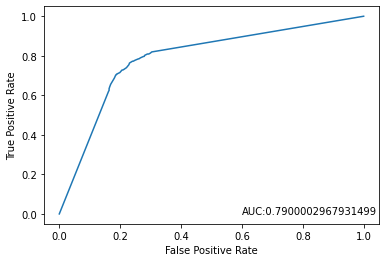

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
#create ROC curve
#y_pred_proba = clf.predict_proba(X_test)[::,1]
metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.6,0,'AUC:'+str(metrics.auc(fpr, tpr)))
plt.show()

Text(0.5, 257.44, 'Predicted label')

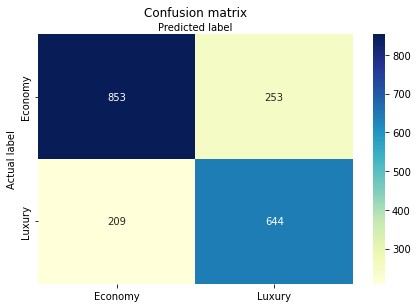

In [ ]:
class_names = ['Economy','Luxury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)).rename(columns={0:'Economy',1:'Luxury'},index={0:'Economy',1:'Luxury'})
, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

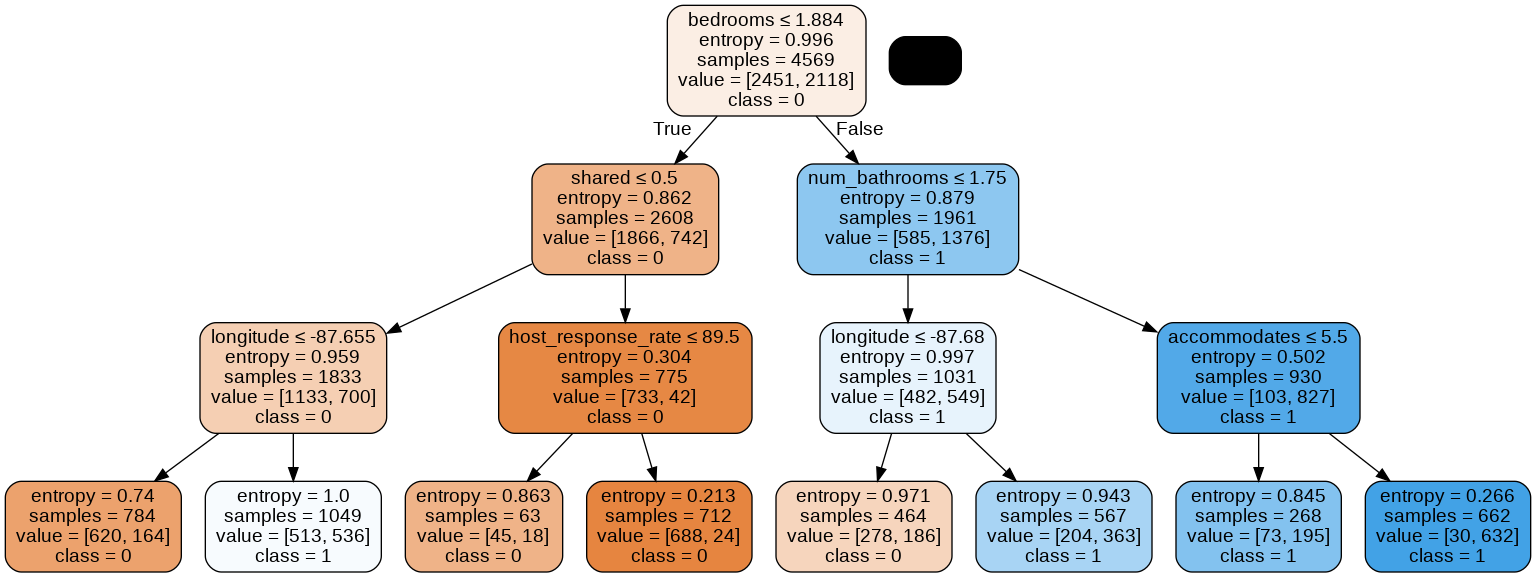

In [ ]:
#visulization
from six import StringIO  
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = new_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('airbnb.png')
Image(graph.create_png())


From our results we can see that our model is fairly strong already. The accuracy is approximately 0.78 (which is slightly better than our logistic regression classifier) and our precision and f1-score for both classes are pretty high. We can see from the confusion matrix that for the Economy class 861 observations were classified correctly (with 245 misses) and 674 Luxury class observations were classified correctly (with 179 misses). Our AUC was higher than 0.8 suggesting that the model is capable of distinguishing the classes as well. Overall, for an initial benchmark the model is fairly decent. 

In [ ]:
#random forest 
clf = RandomForestClassifier(max_depth=12, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8289943848902501
[[940 166]
 [169 684]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1106
           1       0.80      0.80      0.80       853

    accuracy                           0.83      1959
   macro avg       0.83      0.83      0.83      1959
weighted avg       0.83      0.83      0.83      1959



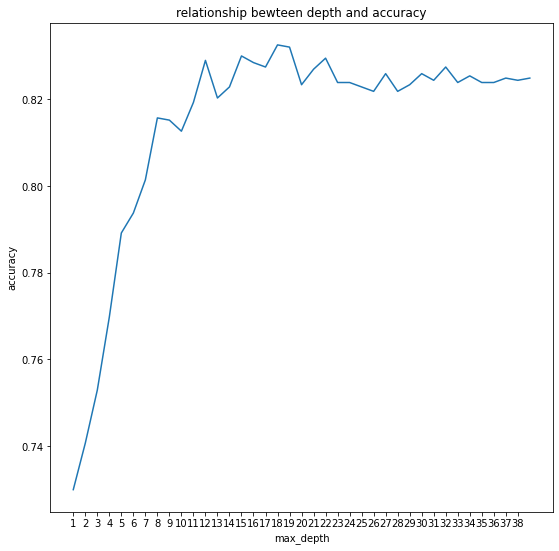

In [ ]:
x = []
y = []
for n in range(1,40):

  clf = RandomForestClassifier(max_depth=n, random_state=0)
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  y.append(metrics.accuracy_score(y_test, y_pred))
  x.append(n)
plt.figure(figsize=(9,9))
plt.plot(x,y)
xticks = np.arange(x[0],x[-1],1)
plt.xticks(xticks)
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.title('relationship bewteen depth and accuracy')
plt.show()

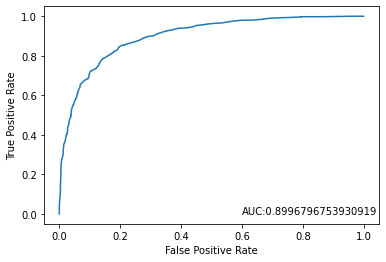

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
#create ROC curve
#y_pred_proba = clf.predict_proba(X_test)[::,1]
metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.6,0,'AUC:'+str(metrics.auc(fpr, tpr)))
plt.show()

Text(0.5, 257.44, 'Predicted label')

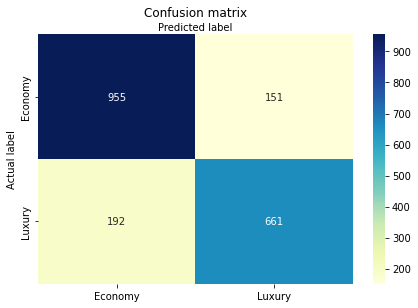

In [ ]:
class_names = ['Economy','Luxury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)).rename(columns={0:'Economy',1:'Luxury'},index={0:'Economy',1:'Luxury'})
, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

As expected, our random forest accuracy exceeds that of all the other models. The accuracy we received from initial benchmark was approximately 0.79. Looking at the classification report we can also see that there is high precision and f1-score for both classes. The model had 909 hits for the Economy class ( 197 misses) and 646 hits for the Luxury class ( 207 misses).  The AUC score, was also the highest so far at approximately 0.88. This is by far our strongest model before pre-processing. 

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 6).fit(X_train, y_train)
# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print(accuracy)
# creating a confusion matrix
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_pred,y_test))

0.6845329249617151
[[895 211]
 [407 446]]
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      1302
           1       0.52      0.68      0.59       657

    accuracy                           0.68      1959
   macro avg       0.67      0.68      0.67      1959
weighted avg       0.71      0.68      0.69      1959



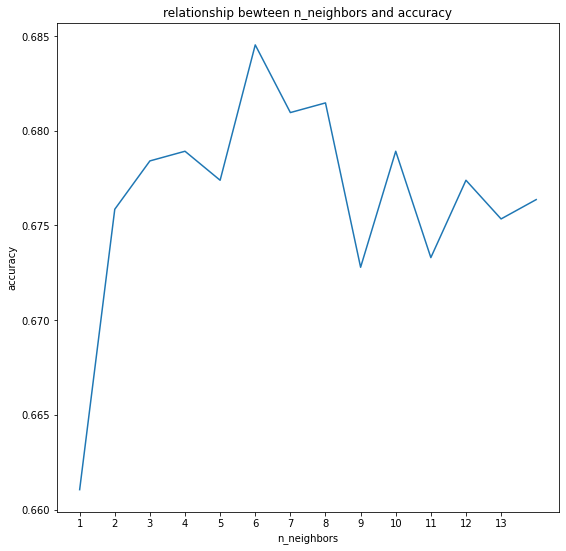

In [ ]:
x = []
y = []
for n in range(1,15):


  knn = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
  accuracy = knn.score(X_test, y_test)
  y.append(accuracy)
  x.append(n)
plt.figure(figsize=(9,9))
plt.plot(x,y)
xticks = np.arange(x[0],x[-1],1)
plt.xticks(xticks)
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')
plt.title('relationship bewteen n_neighbors and accuracy')
plt.show()

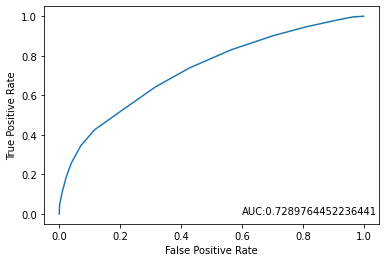

In [ ]:
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
#create ROC curve
#y_pred_proba = clf.predict_proba(X_test)[::,1]
metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.6,0,'AUC:'+str(metrics.auc(fpr, tpr)))
plt.show()

Text(0.5, 257.44, 'Predicted label')

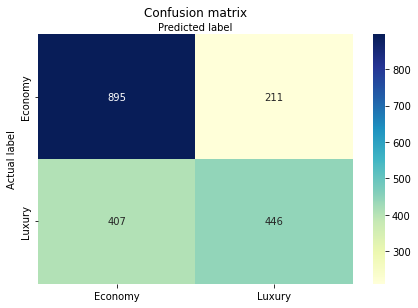

In [ ]:
class_names = ['Economy','Luxury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)).rename(columns={0:'Economy',1:'Luxury'},index={0:'Economy',1:'Luxury'})
, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Our KNN model, with no pre-processing, performed the worst out of all the models. The accuracy of our model is 0.68 (lower than the 0.7 mark). When we take a look at the confusion matrix we can see that the model had 887 hits in the Economy class ( 219 misses) and 448 hits in the Luxury class (405 misses). We can see from this (also from the precision and f1-score) that KNN is much weaker at classifying the Luxury class than our other models. The AUC is still above 0.7 meaning that, the model is capable of distinguishing the two classes from each other. We will try to improve this score, our “with pre-processing” section. 

#Benchmarking (with Preprocessing): 

Since our dataset had a relatively equal distribution of the class variable we decided that oversampling and under sampling (techniques like SMOTE) were not required. Before we went into pre-processing for specific models, we did some overall pre-processing across our dataset. There are two major pre-processing steps we took that impact all the models equally: text processing and changing the way we filled null values. 

In [ ]:
df2 = df.copy()

#feature pre-processing
columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'PriceClass']
features = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'latitude', ' longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
#replace t and f with 1 and 0 
df2.replace(to_replace={'host_is_superhost':{'t':1,'f':0},'host_has_profile_pic':{'t':1,'f':0},'host_identity_verified':{'t':1,'f':0}},
           inplace = True)
review = pd.read_csv('reviews.csv')

In [ ]:
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2384,25218143,2015-01-09,14385014,Ivan,it's a wonderful trip experience. I didn't exc...
1,2384,28475392,2015-03-24,16241178,Namhaitou,This is my first trip using Airbnb. I was a li...
2,2384,30273263,2015-04-19,26101401,Patrick,The reservation was canceled 80 days before ar...
3,2384,30974202,2015-04-30,26247321,Cristina,Sólo puedo decir cosas buenas de Rebecca. La h...
4,2384,31363208,2015-05-04,31293837,SuJung,Rebecca was an absolutely wonderful host.\r<br...


In [ ]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302750 entries, 0 to 302749
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     302750 non-null  int64 
 1   id             302750 non-null  int64 
 2   date           302750 non-null  object
 3   reviewer_id    302750 non-null  int64 
 4   reviewer_name  302750 non-null  object
 5   comments       302472 non-null  object
dtypes: int64(3), object(3)
memory usage: 13.9+ MB


Here we add reviews data of Chicago from Airbnb and do sentiment
analysis on the comment of each hotel.

In [ ]:
# this cell of code takes some time to run
review_text = review.rename(columns={'comments':"text"})
review_text['text'] = review_text['text'].str.replace("[^a-zA-Z#]", " ")
# Make all text lowercase
review_text['text'] = review_text['text'].astype(str).apply(lambda x: x.lower())
# Split the sentence into words like ("i like you") into ["i" "like" "you"]
review_text['text'] = review_text['text'].apply(lambda x: x.split())

# Remove stopwords from text
review_text['clean_text'] = 'na'
stopword = list(stopwords.words('english'))
for index,value in enumerate(review_text['text']): 
  for L in value:
    if L in set(stopword):
      value.remove(L)
  review_text['clean_text'][index] = value 
# Calculate overall sentimental score of each hotel 
scores = {} 
for index,value in enumerate(review_text['clean_text']):
  value = " ".join(value)
  score = sia.polarity_scores(value)
  if 'pos' not in scores.keys():
    scores['pos'] = [score['pos']]
  else:
    scores['pos'].append(score['pos'])
  if 'neg' not in scores.keys():
    scores['neg'] = [score['neg']]
  else:
    scores['neg'].append(score['neg'])
  if 'neu' not in scores.keys():
    scores['neu'] = [score['neu']]
  else:
    scores['neu'].append(score['neu'])
  if 'compound' not in scores.keys():
    scores['compound'] = [score['compound']]
  else:
    scores['compound'].append(score['compound'])
scores_dataframe = pd.DataFrame(scores)
review_text_score = pd.concat([review_text,scores_dataframe],axis=1)

In [ ]:
review_text_scores = review_text_score.groupby('listing_id').mean().reset_index()[['listing_id','pos','neg','neu','compound']]
review_text_scores

,listing_id,pos,neg,neu,compound
0,2384,0.410258,0.014074,0.575663,0.912579
1,7126,0.403053,0.018220,0.576304,0.836953
2,10945,0.430639,0.022083,0.547333,0.818631
3,12068,0.350692,0.027077,0.622308,0.935954
4,12140,0.434714,0.000000,0.565286,0.869414
...,...,...,...,...,...
5505,52632315,0.557500,0.000000,0.442500,0.955200
5506,52636503,0.390000,0.000000,0.610000,0.935550
5507,52674161,0.458000,0.086000,0.456000,0.926500
5508,52685474,0.589500,0.000000,0.410500,0.869800


In [ ]:
df2 =df2.merge(review_text_scores,how='left',left_on='id', right_on='listing_id')

Since we also add sentiment scores into our model as additional features, it’s also essential that we visualization the distribution of the sentiment score of the entire dataset and each group separately:

0.7787779993383166


Text(0.5, 0, 'Compound Sentiment')

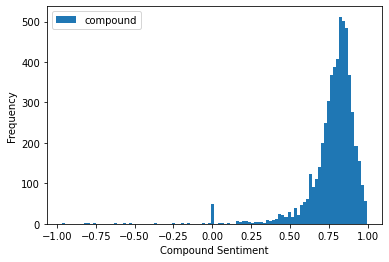

In [ ]:
ax = df2['compound'].plot.hist(stacked=True,bins=100)
print(df2['compound'].mean())
ax.legend()
ax.set_xlabel("Compound Sentiment")

Here, we only visualize the compound score as this sentiment score could reflect sentimental emotion of the comments (The more positive compound is the more positive the text is and the more negative compound is the more negative the text is). We can see that most of our compound scores are distributed above 0.5

Below is distribution of the compound scores of each class:

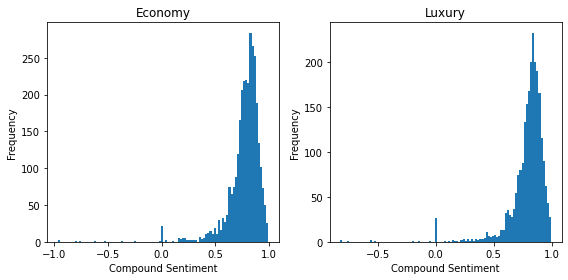

In [ ]:
plt.figure(figsize=(8,4))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
axs = [ax1,ax2]
priceclass = ['Economy','Luxury']
for index in range(len(axs)):
  df2[df2['PriceClass'] == priceclass[index]]['compound'].plot.hist(stacked=True,bins=100,ax=axs[index])
  axs[index].set_title(priceclass[index])
  axs[index].set_xlabel("Compound Sentiment")
plt.tight_layout()

From the compound score graph of each class we can conclude that Luxury is slightly better than Economy.

(Text(0, 0.5, 'quantile compound score'),
 Text(0.5, 1.0, 'quantile of compound score'))

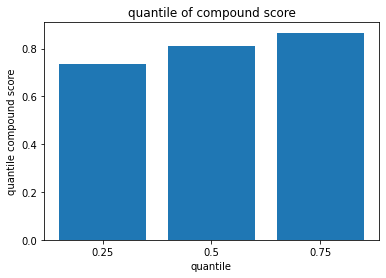

In [ ]:
df2.quantile([0.25,0.5,0.75])[['compound']]['compound']
y = ['0.25','0.5','0.75']
plt.bar(y,df2.quantile([0.25,0.5,0.75])[['compound']]['compound'])
plt.xlabel('quantile')
plt.ylabel('quantile compound score'),plt.title('quantile of compound score')

In [ ]:
#host response rate: na 1466
df2.host_response_rate= df2['host_response_rate'].str.replace("%", '')
df2.host_response_rate = df2['host_response_rate'].astype(float)/100

#host_acceptance_rate: na 1300
df2.host_acceptance_rate= df2['host_acceptance_rate'].str.replace("%", '')
df2.host_acceptance_rate = df2['host_acceptance_rate'].astype(float)/100

#host_is_superhost: na 3 (checked url and they were all superhost)
df2['host_is_superhost'].fillna(1, inplace = True)

#host_has_profile_pic: na 3 (checked url and they all had profile)
df2['host_has_profile_pic'].fillna(1, inplace = True)

# host_identity_verified: na 3 (checked url and they all were verified)
df2['host_identity_verified'].fillna(1, inplace = True)

In [ ]:
#the value type of room_type column is categorical so we need to use dummy variables to replace this in our data
#room_type = pd.get_dummies(df['room_type'],drop_first=True)
for index,value in enumerate(df2['bathrooms_text']):
  if pd.isnull(value):
    df2.loc[index,'bathrooms_text'] = "0 baths"

bathrooms_text column contains bathrooms type and number of bath like "3 shared baths" number == 3, type == "shared bath" 
so we need to divide this into two columns. One is number of bath and the other is type of bath

first we do some changes on the value before division ✈

"Half-bath" ✈ "0.5 baths". 

"Private half-bath" ✈ "0.5 private baths".

"Shared half-bath" ✈ "0.5 shared baths".

"1 bath" ✈ "1 baths".

"1 private bath" ✈ "1 private baths".

"1 shared bath" ✈ "1 shared baths".


In [ ]:
for index, value in enumerate(df['bathrooms_text']):
  if value == 'Half-bath':
    df2.loc[index,'bathrooms_text'] = "0.5 baths"
  elif value == "Private half-bath":
    df2.loc[index,"bathrooms_text"] = "0.5 private baths"
  elif value == "Shared half-bath":
    df2.loc[index,"bathrooms_text"] = "0.5 shared baths"
  elif value == "1 bath":
    df2.loc[index,"bathrooms_text"] = "1 baths"
  elif value == "1 private bath":
    df2.loc[index,"bathrooms_text"] = "1 private baths"
  elif value == "1 shared bath":
    df2.loc[index,"bathrooms_text"] = "1 shared baths"

In [ ]:
df2.head(1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,PriceClass,listing_id,pos,neg,neu,compound
0,2384,https://www.airbnb.com/rooms/2384,20211018161857,2021-10-19,Hyde Park - Walk to University of Chicago,"If you are fully vaccinated, and able to climb...",The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,1.0,0.83,1.0,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",1.0,1.0,"Chicago, Illinois, United States",Hyde Park,NaN,41.7879,-87.5878,Private room in condominium (condo),Private room,1,NaN,1 shared baths,1.0,1.0,"[""Hot water"", ""Gas stove"", ""Essentials"", ""Room...",81.0,3,30,3,3,1125,1125,3.0,1125.0,NaN,t,19,40,55,329,2021-10-19,190,10,2,2015-04-30,2021-09-24,4.99,4.98,4.99,4.98,4.98,4.95,4.94,R17000015609,f,1,0,1,0,2.41,Economy,2384.0,0.410258,0.014074,0.575663,0.912579


now we divide this into two columns. One is number of bath and the other is type of bath

In [ ]:
num = df2['bathrooms_text'].str.split(' ').str[0].astype(float)
df2['num_bathrooms'] = num
type_ = pd.DataFrame(df2['bathrooms_text'].str.split(' ').str[1:])
df2['bathrooms_type'] = type_
for index,value in enumerate(df2['bathrooms_type']):
  df2.loc[index,'bathrooms_type'] = " ".join(value)
print(list(df2.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 

In [ ]:
df2.head(1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,PriceClass,listing_id,pos,neg,neu,compound,num_bathrooms,bathrooms_type
0,2384,https://www.airbnb.com/rooms/2384,20211018161857,2021-10-19,Hyde Park - Walk to University of Chicago,"If you are fully vaccinated, and able to climb...",The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,1.0,0.83,1.0,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",1.0,1.0,"Chicago, Illinois, United States",Hyde Park,NaN,41.7879,-87.5878,Private room in condominium (condo),Private room,1,NaN,1 shared baths,1.0,1.0,"[""Hot water"", ""Gas stove"", ""Essentials"", ""Room...",81.0,...,3,3,1125,1125,3.0,1125.0,NaN,t,19,40,55,329,2021-10-19,190,10,2,2015-04-30,2021-09-24,4.99,4.98,4.99,4.98,4.98,4.95,4.94,R17000015609,f,1,0,1,0,2.41,Economy,2384.0,0.410258,0.014074,0.575663,0.912579,1.0,shared baths


For the replacement of na value in each column, we first calculate the 
average value in each segmentation(the segmentation is based on "neighbourhood_cleansed" column) and the fill na with the corresponding average value in each segmentation.

**note:**

there are certain segmentation contains only na value.


In [ ]:
avg = df2[['neighbourhood_cleansed','bedrooms']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','bedrooms':'avg_bedrooms'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['bedrooms']):
  if pd.isnull(value):
    df2.loc[index,'bedrooms'] = df2['avg_bedrooms'][index]

avg = df2[['neighbourhood_cleansed','review_scores_rating']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_rating':'avg_review_scores_rating'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_rating']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_rating'] = df2['avg_review_scores_rating'][index]

avg = df2[['neighbourhood_cleansed','review_scores_accuracy']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_accuracy':'avg_review_scores_accuracy'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_accuracy']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_accuracy'] = df2['avg_review_scores_accuracy'][index]


avg = df2[['neighbourhood_cleansed','review_scores_cleanliness']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_cleanliness':'avg_review_scores_cleanliness'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_cleanliness']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_cleanliness'] = df2['avg_review_scores_cleanliness'][index]


avg = df2[['neighbourhood_cleansed','review_scores_checkin']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_checkin':'avg_review_scores_checkin'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_checkin']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_checkin'] = df2['avg_review_scores_checkin'][index]


avg = df2[['neighbourhood_cleansed','review_scores_communication']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_communication':'avg_review_scores_communication'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_communication']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_communication'] = df2['review_scores_communication'][index]

avg = df2[['neighbourhood_cleansed','review_scores_location']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_location':'avg_review_scores_location'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_location']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_location'] = df2['avg_review_scores_location'][index]

avg = df2[['neighbourhood_cleansed','review_scores_value']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_value':'avg_review_scores_value'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_value']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_value'] = df2['avg_review_scores_value'][index]

avg = df2[['neighbourhood_cleansed','reviews_per_month']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','reviews_per_month':'avg_reviews_per_month'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['reviews_per_month']):
  if pd.isnull(value):
    df2.loc[index,'reviews_per_month'] = df2['avg_reviews_per_month'][index]

#host_response_rate and host_acceptance_rate
avg = df2[['neighbourhood_cleansed','host_response_rate']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','host_response_rate':'avg_host_response_rate'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['host_response_rate']):
  if pd.isnull(value):
    df2.loc[index,'host_response_rate'] = df2['avg_host_response_rate'][index]

avg = df2[['neighbourhood_cleansed','host_acceptance_rate']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','host_acceptance_rate':'avg_host_acceptance_rate'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['host_acceptance_rate']):
  if pd.isnull(value):
    df2.loc[index,'host_acceptance_rate'] = df2['avg_host_acceptance_rate'][index]

In [ ]:
#beds: na 59
df2.beds.fillna(df2.beds.mean(), inplace = True)
df2.host_listings_count.fillna(method='pad',inplace=True)
df2.neg.fillna(method='pad',inplace=True)
df2.pos.fillna(method='pad',inplace=True)
df2.neu.fillna(method='pad',inplace=True)
df2.compound.fillna(method='pad',inplace=True)

In [ ]:
df2.info()

In [ ]:
room_type = pd.get_dummies(df2['room_type'],drop_first=True).rename(columns={"Hotel room":"Hotel_room","Private room":"Private_room","Shared room":"Shared_room"})
bathrooms_type = pd.get_dummies(df2['bathrooms_type'],drop_first=True).rename(columns={"private baths":"private_baths","shared baths":"shared_baths"})
host_response_time = pd.get_dummies(df2['host_response_time'],drop_first=True).rename(columns={"within a day":"host_response_time1","within a few hours":"host_response_time2","within an hour":"host_response_time3"})

In [ ]:
df2.drop(['room_type', 'bathrooms_text','host_response_time'],axis=1,inplace=True)
df2 = pd.concat([df2,room_type, bathrooms_type,host_response_time],axis=1)

In [ ]:
df2.groupby('neighbourhood_cleansed').count()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_group_cleansed,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,PriceClass,listing_id,pos,neg,neu,compound,num_bathrooms,bathrooms_type,avg_bedrooms,avg_review_scores_rating,avg_review_scores_accuracy,avg_review_scores_cleanliness,avg_review_scores_checkin,avg_review_scores_communication,avg_review_scores_location,avg_review_scores_value,avg_reviews_per_month,avg_host_response_rate,avg_host_acceptance_rate,Hotel_room,Private_room,Shared_room,private_baths,shared_baths,host_response_time1,host_response_time2,host_response_time3
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albany Park,55,55,55,55,55,55,41,55,55,55,55,55,55,32,55,55,55,55,55,51,55,55,55,55,55,41,0,55,55,55,55,0,55,55,55,55,55,55,55,55,...,55,55,55,49,55,55,54,55,55,55,55,55,55,55,49,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55
Archer Heights,5,5,5,5,5,5,4,5,5,5,5,5,5,4,5,5,5,5,5,4,5,5,5,5,5,4,0,5,5,5,5,0,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
Armour Square,66,66,66,66,66,66,45,66,66,66,66,66,66,25,66,66,66,66,66,62,66,66,66,66,66,45,0,66,66,66,66,0,66,66,66,66,66,66,66,66,...,66,66,66,65,66,66,66,66,66,66,66,66,66,66,65,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66
Ashburn,10,10,10,10,10,10,8,10,10,10,10,10,10,8,10,10,10,10,10,8,10,10,10,10,10,8,0,10,10,10,10,0,10,10,10,10,10,10,10,10,...,10,10,10,9,10,10,9,10,10,10,10,10,10,10,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Auburn Gresham,7,7,7,7,7,7,5,7,7,7,7,7,7,5,7,7,7,7,7,6,7,7,7,7,7,5,0,7,7,7,7,0,7,7,7,7,7,7,7,7,...,7,7,7,5,7,7,7,7,7,7,7,7,7,7,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Lawn,7,7,7,7,7,7,3,7,7,7,7,7,7,3,7,7,7,7,7,6,7,7,7,7,7,3,0,7,7,7,7,0,7,7,7,7,7,7,7,7,...,7,7,7,6,7,7,6,7,7,7,7,7,7,7,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
West Pullman,5,5,5,5,5,5,2,5,5,5,5,5,5,2,5,5,5,5,5,4,5,5,5,5,5,2,0,5,5,5,5,0,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,3,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
West Ridge,75,75,75,75,75,75,64,75,75,75,75,75,75,57,75,75,75,75,75,72,75,75,75,75,75,64,0,75,75,75,75,0,75,75,75,75,75,75,75,75,...,75,75,75,68,75,75,74,75,75,75,75,75,75,75,68,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75


In [ ]:
#check host_response_time,host_neighbourhood,host_listings_count,host_total_listings_count
new_features = ['host_response_rate','host_acceptance_rate','host_is_superhost','host_has_profile_pic','host_identity_verified','latitude','longitude','Hotel_room','Private_room','Shared_room','private_baths','shared_baths','num_bathrooms','accommodates','bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month','host_response_time1','host_response_time2','host_response_time3','host_listings_count','pos','neg','compound','neu']
classification = ['PriceClass']
used_data = pd.concat([df2[new_features],df2[classification]],axis=1)

In [ ]:
used_data.dropna(inplace=True)

In [ ]:
used_data.info()

In [ ]:
used_data.replace(to_replace={'PriceClass':{'Economy': 0, 'Luxury': 1} }, inplace = True)

In [ ]:
X = used_data[new_features]
y = used_data[classification]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
logit_model = logit('PriceClass ~host_response_rate+host_acceptance_rate+host_is_superhost+host_has_profile_pic+host_identity_verified+latitude+longitude+Hotel_room+Private_room+Shared_room+private_baths+shared_baths+num_bathrooms+accommodates+bedrooms+beds+minimum_nights+maximum_nights+number_of_reviews+review_scores_rating+review_scores_accuracy+review_scores_cleanliness+review_scores_checkin+review_scores_communication+review_scores_location+review_scores_value+reviews_per_month+host_response_time1+host_response_time2+host_response_time3+host_listings_count+pos+neg+compound+neu',used_data).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.430604
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             PriceClass   No. Observations:                 5473
Model:                          Logit   Df Residuals:                     5437
Method:                           MLE   Df Model:                           35
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.3705
Time:                        08:31:09   Log-Likelihood:                -2356.7
converged:                       True   LL-Null:                       -3743.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1035.8149     89.907     11.521      0.000   

In [ ]:
#logistic regression
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[791 135]
 [215 501]]
Accuracy: 0.7868453105968332
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       926
           1       0.79      0.70      0.74       716

    accuracy                           0.79      1642
   macro avg       0.79      0.78      0.78      1642
weighted avg       0.79      0.79      0.78      1642



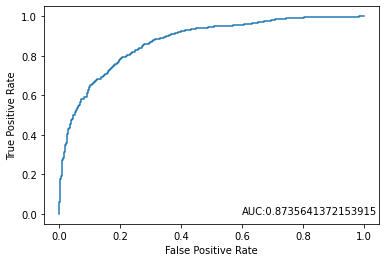

In [ ]:
#create ROC curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.6,0,'AUC:'+str(metrics.auc(fpr, tpr)))
plt.show()

Text(0.5, 257.44, 'Predicted label')

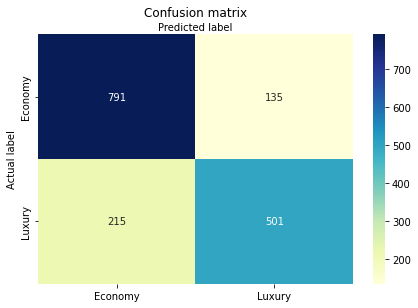

In [ ]:
class_names = ['Economy','Luxury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)).rename(columns={0:'Economy',1:'Luxury'},index={0:'Economy',1:'Luxury'})
, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

We can see from the results that when preprocessing is done, that the accuracy is approximately 0.79. Our classifier correctly identified 791 elements as Economy out of 926 possible elements (135 incorrectly classified) and classified 501 elements Luxury out of 716 possible elements (215 incorrectly classified). The AUC is also 0.87 and indicates that our model is able to distinguish the two class models pretty well. We can also see that our precision for both 0 and 1 is above .7 and likewise with our f1-score. So when comparing the model with our benchmark the accuracy of our new model increased by 3% (and our AUC score increased by 0.03). So with pre-processing we can see that our model has slightly better performance than without pre-processing.

In [ ]:
#decision trees
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)# max_depth = 5 is the optimal value
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8038976857490865
[[802 124]
 [198 518]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       926
           1       0.81      0.72      0.76       716

    accuracy                           0.80      1642
   macro avg       0.80      0.79      0.80      1642
weighted avg       0.80      0.80      0.80      1642



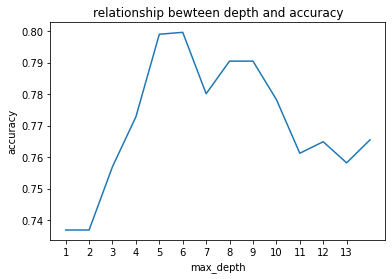

In [ ]:
x = []
y = []
for n in range(1,15):

  clf = DecisionTreeClassifier(criterion="entropy", max_depth=n)
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  y.append(metrics.accuracy_score(y_test, y_pred))
  x.append(n)
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
plt.plot(x,y)
xticks = np.arange(x[0],x[-1],1)
plt.xticks(xticks)
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.title('relationship bewteen depth and accuracy')
plt.show()

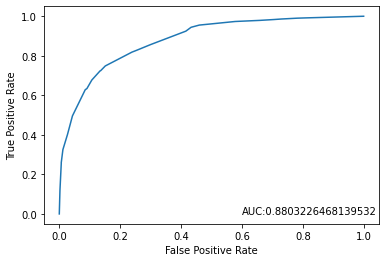

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
#create ROC curve
#y_pred_proba = clf.predict_proba(X_test)[::,1]
metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.6,0,'AUC:'+str(metrics.auc(fpr, tpr)))
plt.show()

Text(0.5, 257.44, 'Predicted label')

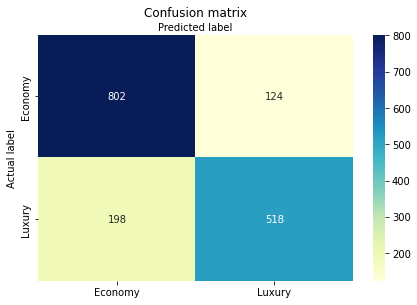

In [ ]:
class_names = ['Economy','Luxury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)).rename(columns={0:'Economy',1:'Luxury'},index={0:'Economy',1:'Luxury'})
, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

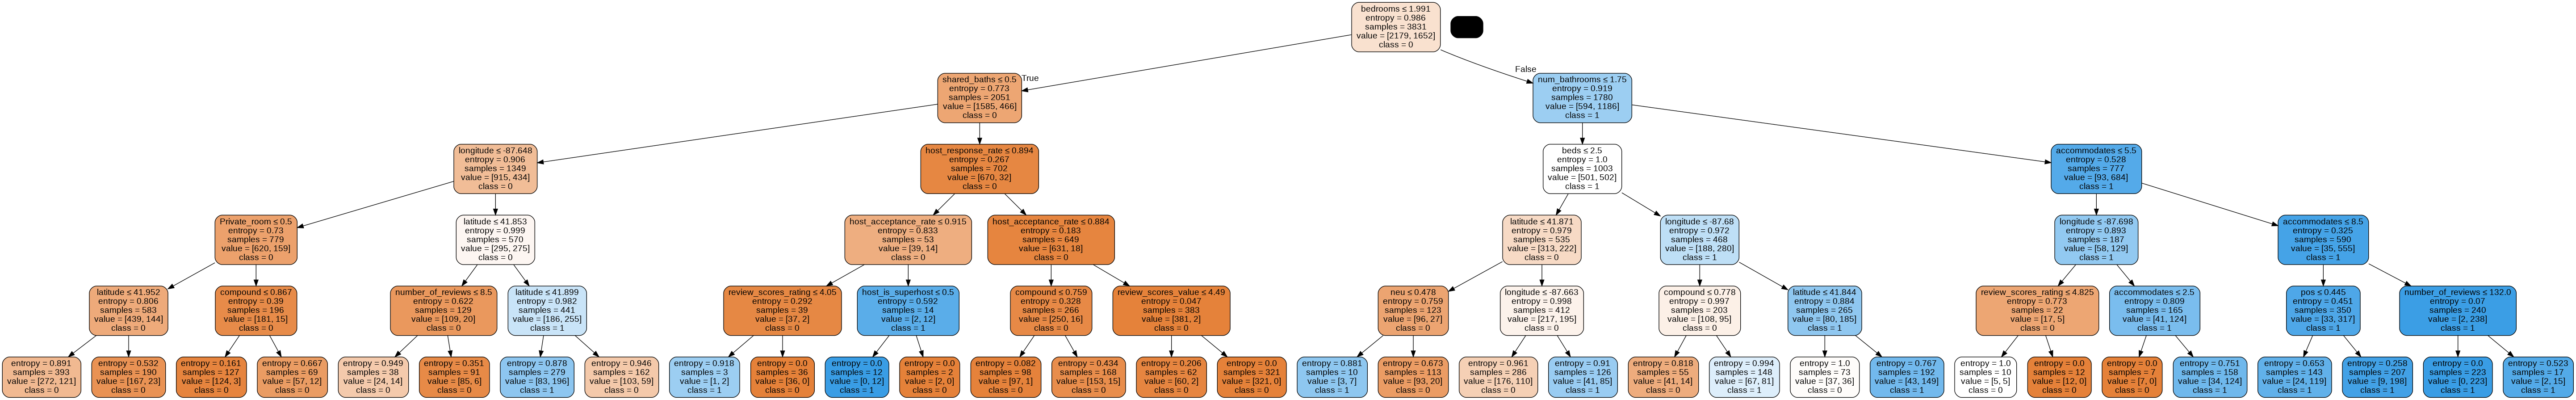

In [ ]:
#visulization
from six import StringIO  
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = new_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('airbnb.png')
Image(graph.create_png())

From our results we can see that our model is strong. The accuracy is approximately 0.80 (which is slightly better than our logistic regression classifier and increased 0.2 compared with benchmark) and our precision and f1-score for both classes are pretty high. We can see from the confusion matrix that for the Economy class 803 observations were classified correctly (with 123 misses) and 506 Luxury class observations were classified correctly (with 210 misses). Our AUC was 0.87 suggesting that the model is capable of distinguishing the classes as well. Overall, our decision tree model is slightly better than the benchmark.

In [ ]:
#random forest 
clf = RandomForestClassifier(max_depth=12, random_state=0)#max_depth = 12 is the optimal 
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8398294762484775
[[817 109]
 [154 562]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       926
           1       0.84      0.78      0.81       716

    accuracy                           0.84      1642
   macro avg       0.84      0.83      0.84      1642
weighted avg       0.84      0.84      0.84      1642



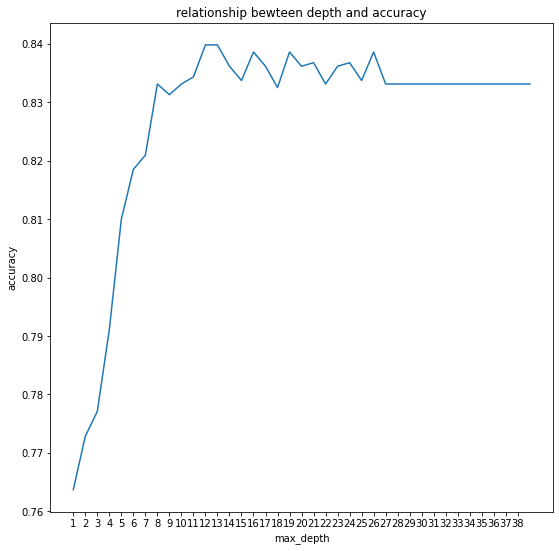

In [ ]:
x = []
y = []
for n in range(1,40):

  clf = RandomForestClassifier(max_depth=n, random_state=0)
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  y.append(metrics.accuracy_score(y_test, y_pred))
  x.append(n)
plt.figure(figsize=(9,9))
plt.plot(x,y)
xticks = np.arange(x[0],x[-1],1)
plt.xticks(xticks)
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.title('relationship bewteen depth and accuracy')
plt.show()

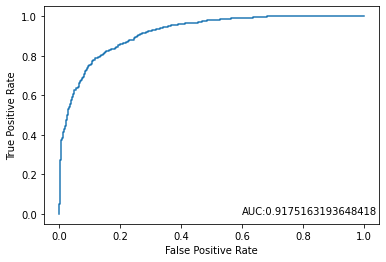

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
#create ROC curve
#y_pred_proba = clf.predict_proba(X_test)[::,1]
metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.6,0,'AUC:'+str(metrics.auc(fpr, tpr)))
plt.show()

Text(0.5, 257.44, 'Predicted label')

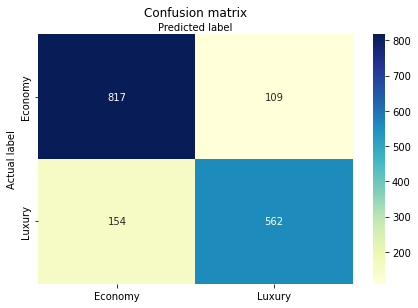

In [ ]:
class_names = ['Economy','Luxury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)).rename(columns={0:'Economy',1:'Luxury'},index={0:'Economy',1:'Luxury'})
, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

As expected, our random forest accuracy exceeds that of all the other models. The accuracy we received from this model was approximately 0.82 which increased by 3%. Looking at the classification report we can also see that there is high precision and f1-score for both classes. The model had 812 hits for the Economy class (114 misses) and 532 hits for the Luxury class ( 184 misses).  The AUC score, was also the highest so far at approximately 0.90. This is by far our strongest model.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)#n_neighbors=7 is the optimal 
# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print("Accuracy:",accuracy)
# creating a confusion matrix
knn_predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, knn_predictions)
#print(cm)
print(classification_report(y_test, y_pred))

Accuracy: 0.7302070645554202
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       926
           1       0.84      0.78      0.81       716

    accuracy                           0.84      1642
   macro avg       0.84      0.83      0.84      1642
weighted avg       0.84      0.84      0.84      1642



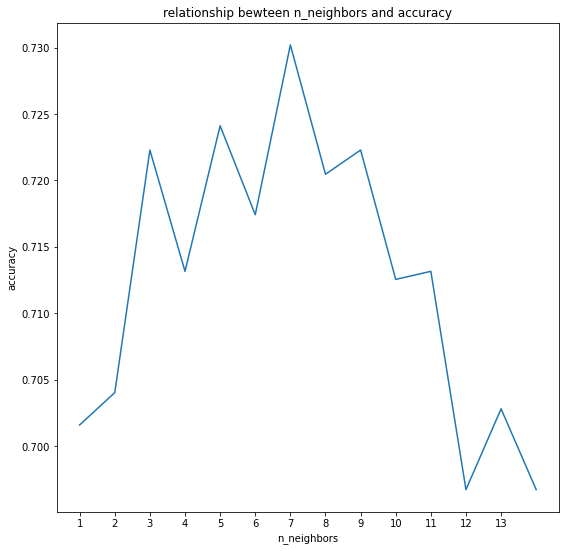

In [ ]:
x = []
y = []
for n in range(1,15):


  knn = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
  accuracy = knn.score(X_test, y_test)
  y.append(accuracy)
  x.append(n)
plt.figure(figsize=(9,9))
plt.plot(x,y)
xticks = np.arange(x[0],x[-1],1)
plt.xticks(xticks)
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')
plt.title('relationship bewteen n_neighbors and accuracy')
plt.show()

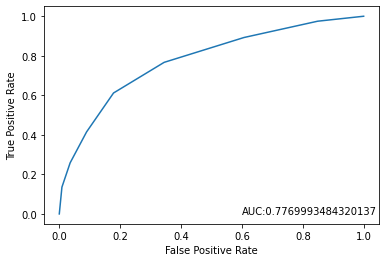

In [ ]:
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
#create ROC curve
#y_pred_proba = clf.predict_proba(X_test)[::,1]
metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.6,0,'AUC:'+str(metrics.auc(fpr, tpr)))
plt.show()

Text(0.5, 257.44, 'Predicted label')

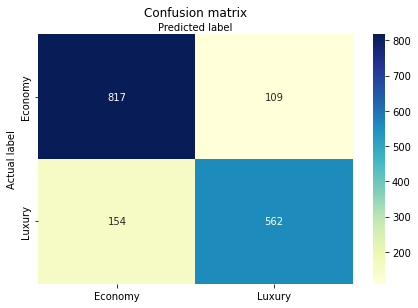

In [ ]:
class_names = ['Economy','Luxury'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)).rename(columns={0:'Economy',1:'Luxury'},index={0:'Economy',1:'Luxury'})
, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Our KNN model, with pre-processing, remain the worst out of all the models. The accuracy of our model is 0.72. When we take a look at the confusion matrix we can see that the model had 811 hits in the Economy class ( 115 misses) and 372 hits in the Luxury class (344 misses). We can see from this (also from the precision and f1-score) that KNN is still much weaker at classifying the Luxury class than our other models. The AUC is 0.78 meaning that, the model is capable of distinguishing the two classes from each other. Despite our KNN model has the worst performance among all of the model in this section, the accuracy of the KNN model increased by 4% compare with without pre-processing. So this is a strong indicator that our data pre-processing has positive impact on our model.

# Key takeaways

1.	For logistic regression, our pre-processed model yielded better results than our benchmark model. We saw a 3% increase in accuracy, but even with this increase it was still not our best performing model. 
2.	With decision tree, our model’s accuracy increased by 2% when using the pre-processed data. It performed slightly better than the logistic regression. 
3.	For random forest, this machine learning model out performed all of other models both in benchmarking and with pre-processing. This is because random forest has a strong noise immunity capacity and uses ensemble methods to get the best results. The only down side to this model is the time and space complexity.
4.	With KNN, we had the least success. The model performed the worst in most metrics. Although the accuracy increased by feeding the model with pre-processed data, it still was much weaker than the other models, especially when classifying the Luxury class.




# Conclusion

Our goal with this project was to use the data we received from Airbnb to suggest a method of grouping and presenting the appropriate price into two segments (economy and luxury). By implementing the machine learning methods we learned from the class, we were able to successfully accomplish this. The random forest method (the most accurate model we created) helps users to make appropriate decisions regarding pricing with 84% accuracy. Areas of improvement that we would employ upon further expansion of this project would be: multi-class classification (not just economy and luxury, but also categories in between) and further accuracy improvement. Overall, we learned that machine learning is very effective and that Airbnb should employ this technique (if they haven’t don’t so already) to improve their service quality. 